In [1]:
import torch, torchvision
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 0 to use
torch.cuda.current_device()

0

In [3]:
import random
import torch.backends.cudnn as cudnn
import numpy as np

def seed_fix(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    np.random.seed(seed)
    
SEED = 23
seed_fix(SEED) 

In [4]:
exp_name = 'bottleneck_test3'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# 기존 코드와 동일한 부분
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

EPOCHS = 300
BATCH_SIZE = 64

# CIFAR-10 데이터셋을 불러옴
trainset = datasets.CIFAR10(
    root='./.data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(
        #     brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2
        # ),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)
testset = datasets.CIFAR10(
    root='./.data/',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
    ])
)

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
    
import torch.nn as nn
import torch.nn.functional as F

# class BottleneckBlock(nn.Module):
#     expansion = 4

#     def __init__(self, in_planes, planes, stride=1, dropout_prob=0.5):
#         super(BottleneckBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(planes * self.expansion)
#         self.dropout = nn.Dropout(dropout_prob)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != planes * self.expansion:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(planes * self.expansion)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.dropout(out)
#         out = F.relu(self.bn2(self.conv2(out)))
#         out = self.dropout(out)
#         out = self.bn3(self.conv3(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         out = self.dropout(out)
#         return out

# class BottleneckResNet(nn.Module):
#     def __init__(self, num_classes=10, block=BottleneckBlock, num_blocks=[3, 4, 6, 3]):
#         super(BottleneckResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.linear = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks - 1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avg_pool(out)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, dropout_prob=0.0):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout 레이어 추가

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.dropout(out)  # Dropout 레이어 적용
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BottleneckResNet(nn.Module):
    def __init__(self, num_classes=10, block=BottleneckBlock, num_blocks=[3, 4, 6, 3]):
        super(BottleneckResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model = BottleneckResNet().to(DEVICE)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


# 훈련 및 테스트 손실을 저장할 리스트 생성
train_losses = []
test_losses = []

# train 및 evaluate 함수는 그대로 사용
def train(model, train_loader, optimizer):
    running_loss = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
            
        
        
        running_loss += loss.item() * data.size(0)
    return running_loss

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

# 조기학습 종료
patience_limit = 15
patience_check = 0

# Loss curve를 그리기 위한 리스트 생성
train_losses = []
test_losses = []

# 에폭(epoch)별로 학습 및 테스트 수행
best_acc = 0
best_loss = 1e9
best_epoch = 0

for epoch in range(1, EPOCHS + 1):
    running_loss = train(model, train_loader, optimizer)
    epoch_loss = running_loss / len(train_loader.dataset)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    scheduler.step()
        
    # 훈련 및 테스트 손실 기록
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        best_acc = test_accuracy
        patience_check = 0
    else:
        patience_check += 1
        
    if patience_check >= patience_limit:
        break
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.619140
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.364949
Train Epoch: 1 [25600/50000 (51%)]	Loss: 3.319500
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.009441
[1] Test Loss: 3.1528, Accuracy: 26.88%
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.043744
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.934227
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.643281
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.015571
[2] Test Loss: 1.6369, Accuracy: 37.71%
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.949765
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.634245
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.620512
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.704788
[3] Test Loss: 1.5207, Accuracy: 44.32%
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.481886
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.336316
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.602701
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.386091
[4] Test Loss: 1.5761, A

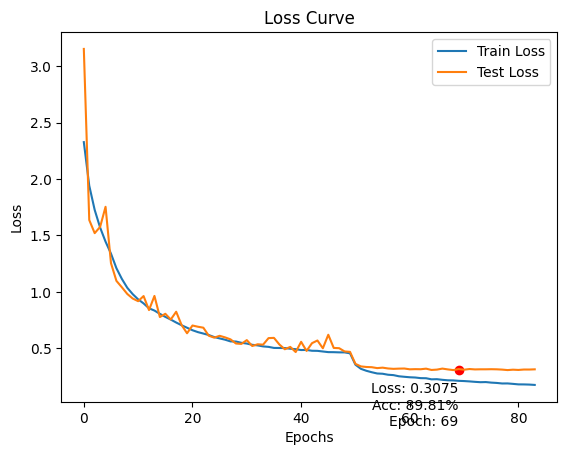

In [6]:

# Loss curve를 그림
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Loss가 가장 작은 지점에 빨간 점을 찍고 주석을 추가
plt.scatter(best_epoch, best_loss, color='red', marker='o')
plt.annotate(f'Loss: {best_loss:.4f}\nAcc: {best_acc:.2f}%\nEpoch: {best_epoch}', (best_epoch, best_loss), textcoords="offset points", xytext=(0, -40), ha='right')

plt.savefig(f'./plot/{exp_name}_loss_curve.png')

In [7]:
torch.save(model.state_dict(), f'./save_weights/{exp_name}.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('conv1.weight', tensor([[[[-2.4708e-03, -3.5865e-02, -2.6637e-02,  ...,  2.2196e-03,
           -6.8981e-02, -1.9859e-02],
          [-4.3674e-03, -3.7455e-02, -6.4012e-02,  ..., -1.3007e-02,
           -1.6982e-02, -1.2669e-02],
          [-3.7856e-02, -7.1666e-02, -8.2130e-02,  ..., -1.5842e-02,
           -7.9521e-03, -1.1361e-02],
          ...,
          [-3.2153e-02, -1.3186e-01, -1.9829e-01,  ..., -1.5103e-01,
           -7.3614e-02, -5.2165e-02],
          [-3.9389e-02, -8.9684e-02, -1.7705e-01,  ..., -1.2601e-01,
           -7.5090e-02, -6.5675e-02],
          [-2.1373e-02, -2.6320e-02, -1.2193e-01,  ..., -9.5500e-02,
           -3.6060e-02, -1.5012e-02]],

         [[ 1.5320e-02,  8.0119e-04, -1.3141e-03,  ...,  2.9348e-02,
           -6.9730e-03,  4.5822e-02],
          [ 4.0676e-02,  1.6298e-02,  1.0452e-02,  ...,  3.2491e-02,
            2.5053e-02,  5.5879e-02],
          [ 3.1251e-02,  2.4072e-02,  2.2062e-02,  ...,  3.3166e-

In [8]:
load_model = BottleneckResNet().to(DEVICE)
load_model.load_state_dict(torch.load(f'./save_weights/{exp_name}.pt'))

<All keys matched successfully>

In [16]:
load_model.eval()

BottleneckResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_